# Bulk Phonons Example Notebook

This notebook provides an example of using LatticeDynamics.jl for a bulk phonon calculation. The example is NaCl and should be easily extendable to crystals with more or less atoms in the unit cell.

### Load LatticeDynamics.jl

In [1]:
dir_containing_latticedynamicsjl = "" #put here the path to the directory containing LatticeDynamics.jl
push!(LOAD_PATH, dir_containing_latticedynamicsjl);
using LatticeDynamics

### Construct the crystal

In [2]:
# lattice parameter
a = 5.64

# construct the unit cell
# Each atom gets a list [element name, fractional coordinate position]
unitCell = [ ["Na", [0.0, 0.0, 0.0] ], 
             ["Cl", [0.5, 0.5, 0.5] ] ]

# Primitive lattice vectors (FCC here)
a1 = [a/2, 0., a/2]
a2 = [a/2, a/2, 0.]
a3 = [0., a/2, a/2]
latticeVectors = [a1, a2, a3]

# cutoff for short-range interactions in angstoms
# atoms farther away than this will not interact
cutoff = 5.0

# make Crystal
NaCl = Crystal(unitCell, latticeVectors, cutoff);

### Define the couplings

Only radial short-range interactions and long-range coulomb interactions are supported. 

For a short-range radial potential $V=V(|r_i - r_j|)$, the force constant matrices for the interaction between atoms $i$ and $j$ take the form
$$ \Phi(i,j) = \frac{rr^T}{|r|^2}(A_{ij} - B_{ij}) + IB_{ij} $$
where $r=r_i-r_j$, $I$ is the 3x3 identity matrix, $A_{ij}$ is the radial force constant, and $B_{ij}$ is the tangential force constant. Generally $A_{ij}$ and $B_{ij}$ depend on the form of $V$ but here they are treated as phenomenological parameters.

So for each pair of atoms $(i,j)$ in the unit cell, we define a pair of parameters $(A_{ij}, B_{ij})$ and store it in a matrix structure.

In [3]:
# Couplings (A, B) = (radial force const, tangential force cont.)
nacl_params = (-1.0, -0.7)
nana_params = (-1.0, 0.7)
clcl_params = (-1.2, -0.2)
couplings = [[nana_params, nacl_params],
             [nacl_params, clcl_params]];

# if you want to include long-range coulomb effects, define effective charge values
z = 0.33
charges = [z, -z];

### Define Brillouin zone path and Compute Dispersion

In [4]:
# high symmetry points
G = 2π/a
Γ = zeros(3)
K = [3*G/4, 3*G/4, 0.0]
X = [0.0, G, 0.0]
L = [G/2, G/2, G/2]
W = [G/2, G, 0.0];

# build path through BZ
# the second argument to buildPath is the point density 
# (i.e., how many points per inverse angstrom to compute for along the path)
qPath, qPathParts = buildPath([Γ, X, W, K, Γ, L], 100)
qLabels = ["Γ", "X", "W", "K", "Γ", "L"]

# get dispersion without coulomb effects
disp, modes = getDispersion(qPath, NaCl, couplings);

# or with coulomb:
#disp, modes = getDispersion(qPath, NaCl, couplings, charges);

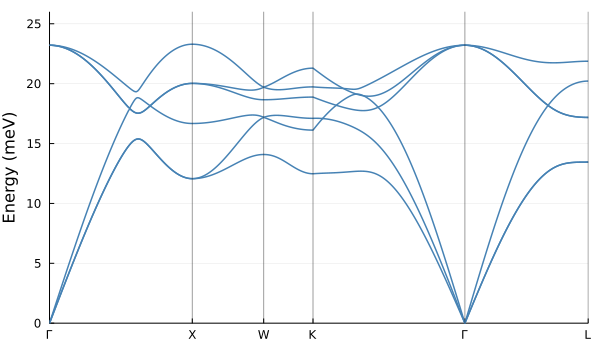

In [5]:
plotDispersion(disp, qPathParts, qLabels, ylims=[0, 26])

### Look at normal modes

In [6]:
# modes[i] contains the normalized eigenvectors for the ith wavevector in the qPath
# so since Γ is first, these are the pure acoustic and optical modes at Γ
Γmodes = modes[1];
acoustic_modes = Γmodes[:,1:3]
optical_modes = Γmodes[:,4:6]

6×3 Matrix{ComplexF64}:
  0.77885+0.0im       0.0+0.0im       0.0+0.0im
      0.0+0.0im   0.77885+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im   0.77885+0.0im
 -0.62721+0.0im       0.0+0.0im       0.0+0.0im
      0.0+0.0im  -0.62721+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im  -0.62721-0.0im

# Using your own force constants

The 3x3 force constant matrices relating atoms $i$ and $j$ are constructed by a method $\phi$ which has signature 

`φ(bondᵢⱼ::Vector{T} where T, A::Real, B::Real)`

Here, bond_ij is the vector pointing between the atoms while A and B are the radial and tangential force constant parameters used in the calculation. However, if you want to use your own force constant matrices, you can overwrite this function to return the 3x3 matrices you want. Here is a template for doing this.

In [8]:
# To read in your own force constants, you must overwrite the ϕ method in LatticeDynamics.jl
# First ϕ must be explicitly imported
import LatticeDynamics.φ

# use the couplings "matrix" to store indices for your atoms in the unit cell, e.g.:
couplings = [ [(1, 1), (1, 2)], 
              [(1, 2), (2, 2)] ]

# now keeping the same function signature, change the body of the function to return the 3x3 matrices you want
function φ(bondᵢⱼ::Vector, A::Real, B::Real)
        ## put your desired force constant matrices here
        ## You can use A and B here as indices for your atoms
        ## so something like this maybe:
        #if A==1 && B==1
        #    myforcematrix = #3x3 force constant matrix between atom1 and atom1
        #elseif A==1 && B==2
        #    myforcematrix = #3x3 force constant matrix between atom1 and atom2
        #elseif A==2 && B==2
        #    myforcematrix = #3x3 force constant matrix between atom2 and atom2
        #end
        #return myforcematrix
end

φ (generic function with 1 method)